# Chicago taxi trips visualisation

In [2]:
from io import StringIO
import os

import boto3
import pandas as pd
pd.set_option('display.max_columns', 50) #expand the displayed column to 50

import seaborn as sns
import matplotlib.pyplot as plt

from pandasql import sqldf

In [3]:
# add the AWS credential into .env file, this will need to be give for the boto3.client to allow the access to S3
AWS_Access_key = os.getenv('AWS_Access_key')
AWS_Secret_access_key = os.getenv('AWS_Secret_access_key')

In [4]:
def read_csv_from_s3(bucket: str, path:str, file_name:str) ->pd.DataFrame:
    '''
    Download a csv file from S3 bucket
    
    Parameters
    ----------
    bucket : str    
        The bucket where the files
    path : str
        The folders to the file
    filename : str
        Name of the file
    Returns
    -------
    pd.DataFrame
        A DataFrame of the downloaderd file
    '''
    
    s3 = boto3.client('s3', 
                      aws_access_key_id = AWS_Access_key, 
                      aws_secret_access_key= AWS_Secret_access_key
                    )

    full_path = f'{path}{file_name}'

    object = s3.get_object(Bucket= bucket, Key=full_path) # in boto3 the paraméters is always start with upper case (ie: Bucket=, Key= )
    object = object['Body'].read().decode('utf-8')
    output_df = pd.read_csv(StringIO(object)) #StringIO saves the variable into memory, don't need fizikal file

    return output_df

In [5]:
# credential for S3 client and the paths.
s3 = boto3.client('s3', 
                    aws_access_key_id = AWS_Access_key, 
                    aws_secret_access_key= AWS_Secret_access_key
                )

my_bucket = 'chichago-taxi'

community_areas_path = 'transformed_data/community_areas/'
company_path = 'transformed_data/company/'
date_path = 'transformed_data/date/'
payment_type_path = 'transformed_data/payment_type/'
taxi_trips_path = 'transformed_data/taxi_trips/'
weather_path = 'transformed_data/weather/'

### Read all master tables and main tables

In [6]:
# read the all master table
community_areas = read_csv_from_s3( bucket= my_bucket, path= community_areas_path, file_name= 'community_areas_master.csv')
company = read_csv_from_s3( bucket= my_bucket, path= company_path, file_name= 'company_master.csv')
date = read_csv_from_s3( bucket= my_bucket, path= date_path, file_name= 'date_dimension.csv')
paymet_type = read_csv_from_s3( bucket= my_bucket, path= payment_type_path, file_name= 'payment_type_master.csv')


In [7]:
# create two 0 list for the taxi trips and the weather data
taxi_trip_file_name_list = [] # for title of visualisation
trip_list = []
weather_list = []

In [8]:
# with for loop read the all taxi trips (daily updated) csv file from the S3 bucket.
for file in s3.list_objects(Bucket=my_bucket, Prefix=taxi_trips_path)['Contents']:
    taxi_trips_key = file['Key'] # its return: first 'transformed_data/taxi_trips/' and else 'transformed_data/taxi_trips/with the file name'
   
    if taxi_trips_key.split('/')[-1].strip() != '': # Split the folder/file address by /, then check that the list's last part is not empty, whit this excluded the first result of taxi_trips_key 
        if taxi_trips_key.split('.')[1] == 'csv': #  the file extension was defined to csv

            filename = taxi_trips_key.split('/')[-1] # Split by /, then hold the last part as file name
            
            trip = read_csv_from_s3(bucket= my_bucket, path= taxi_trips_path, file_name= filename) #read teh file

            trip_list.append(trip) #concatenate the csv's into the previously defined list
            taxi_trip_file_name_list.append(filename)
            print(f'{filename} has been added.') #print the response     

taxi_2024-09-30.csv has been added.
taxi_2024-10-01.csv has been added.
taxi_2024-10-02.csv has been added.
taxi_2024-10-03.csv has been added.
taxi_2024-10-04.csv has been added.
taxi_2024-10-05.csv has been added.
taxi_2024-10-06.csv has been added.
taxi_2024-10-07.csv has been added.
taxi_2024-10-08.csv has been added.
taxi_2024-10-09.csv has been added.
taxi_2024-10-10.csv has been added.
taxi_2024-10-11.csv has been added.
taxi_2024-10-12.csv has been added.
taxi_2024-10-13.csv has been added.
taxi_2024-10-14.csv has been added.
taxi_2024-10-15.csv has been added.
taxi_2024-10-16.csv has been added.
taxi_2024-10-17.csv has been added.
taxi_2024-10-18.csv has been added.
taxi_2024-10-19.csv has been added.
taxi_2024-10-20.csv has been added.
taxi_2024-10-21.csv has been added.
taxi_2024-10-22.csv has been added.
taxi_2024-10-23.csv has been added.
taxi_2024-10-24.csv has been added.
taxi_2024-10-25.csv has been added.
taxi_2024-10-26.csv has been added.
taxi_2024-10-27.csv has been

In [9]:
trips = pd.concat(trip_list, ignore_index=True) #combine multiple DataFrames into a single DataFrame, resetting the index.

In [10]:
trips.head(1) #check the first row

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area_id,dropoff_community_area_id,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,payment_type_id,company_id
0,f56eeaff25c14808d1626fc70e83698c01968321,799deebf2f513dbebcad07d26fedd03920ea747cb97055...,2024-09-30T23:45:00.000,2024-09-30T23:45:00.000,412,0.0,32,8,8.0,0.0,0.0,0.0,8.0,41.878866,-87.625192,41.899602,-87.633308,2024-09-30 23:00:00,1,1


In [11]:
# with for loop read the all csv of weather file (daily updated) from the S3 bucket, all works similar that case of the taxi trips 
for file in s3.list_objects(Bucket=my_bucket, Prefix=weather_path)['Contents']:
    file_key = file['Key']

    if file_key.split('/')[-1].strip() != '':
        if file_key.split('.')[1] == 'csv':

            filenameweather = file_key.split('/')[-1]
            #print(filenameweather)
            weather = read_csv_from_s3(bucket= my_bucket, path= weather_path, file_name= filenameweather)

            weather_list.append(weather)
            print(f'{filenameweather} has been added.')       

        

weather_2024-09-30.csv has been added.
weather_2024-10-01.csv has been added.
weather_2024-10-02.csv has been added.
weather_2024-10-03.csv has been added.
weather_2024-10-04.csv has been added.
weather_2024-10-05.csv has been added.
weather_2024-10-06.csv has been added.
weather_2024-10-07.csv has been added.
weather_2024-10-08.csv has been added.
weather_2024-10-09.csv has been added.
weather_2024-10-10.csv has been added.
weather_2024-10-11.csv has been added.
weather_2024-10-12.csv has been added.
weather_2024-10-13.csv has been added.
weather_2024-10-14.csv has been added.
weather_2024-10-15.csv has been added.
weather_2024-10-16.csv has been added.
weather_2024-10-17.csv has been added.
weather_2024-10-18.csv has been added.
weather_2024-10-19.csv has been added.
weather_2024-10-20.csv has been added.
weather_2024-10-21.csv has been added.
weather_2024-10-22.csv has been added.
weather_2024-10-23.csv has been added.
weather_2024-10-24.csv has been added.
weather_2024-10-25.csv ha

In [12]:
weather = pd.concat(weather_list, ignore_index=True) #combine multiple DataFrames into a single DataFrame, resetting the index.

In [13]:
weather.head(1) #check the first row

,datetime,temperature,wind_speed,rain,precipitation
0,2024-09-30 00:00:00,18.7,21.3,0.0,0.0


### Join them together

In [14]:
# concat the two main DataFrame along the datetime
trips_full = pd.merge(trips, weather, left_on= 'datetime_for_weather', right_on= 'datetime', how= 'inner')
trips_full = trips_full.drop(columns=['datetime'])

In [15]:
# change the company_id to real company names
trips_full = pd.merge(trips_full, company, left_on= 'company_id', right_on= 'company_id', how= 'inner')
trips_full = trips_full.drop(columns=['company_id'])

In [16]:
# change the payment_type_id to payment_type
trips_full = pd.merge(trips_full, paymet_type, left_on= 'payment_type_id', right_on= 'payment_type_id', how= 'inner')
trips_full = trips_full.drop(columns=['payment_type_id'])

In [17]:
# change the community_areas_id to community name
trips_full = pd.merge(trips_full, community_areas, left_on= 'pickup_community_area_id', right_on= 'area_code', how= 'inner')
trips_full = trips_full.drop(columns=['pickup_community_area_id', 'area_code'])
trips_full.rename(columns={'community_name': 'pickup_community_area_name'}, inplace= True)

In [18]:
trips_full = pd.merge(trips_full, community_areas, left_on= 'dropoff_community_area_id', right_on= 'area_code', how= 'inner')
trips_full = trips_full.drop(columns=['dropoff_community_area_id', 'area_code'])

trips_full.rename(columns={'community_name': 'dropoff_community_area_name'}, inplace= True)

In [19]:
trips_full.head(1)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,temperature,wind_speed,rain,precipitation,company,payment_type,pickup_community_area_name,dropoff_community_area_name
0,f56eeaff25c14808d1626fc70e83698c01968321,799deebf2f513dbebcad07d26fedd03920ea747cb97055...,2024-09-30T23:45:00.000,2024-09-30T23:45:00.000,412,0.0,8.0,0.0,0.0,0.0,8.0,41.878866,-87.625192,41.899602,-87.633308,2024-09-30 23:00:00,21.9,9.0,0.0,0.0,Tac - Yellow Cab Association,Cash,Loop,Near North Side


In [20]:
# for merge the date master table, convert the date and the trip_start_timestamp to similar type.
date['date'] = pd.to_datetime(date['date'])
trips_full ['trip_start_timestamp'] = pd.to_datetime(trips_full ['trip_start_timestamp']) # this row results: from 2024-09-30T23:45:00.000 to 2024-09-30 23:45:00

trips_full['trip_start_date'] = trips_full ['trip_start_timestamp']

trips_full['trip_start_date'] = trips_full ['trip_start_timestamp'].dt.date # the .dt.date remove the time so the date only stay
trips_full['trip_start_date'] = pd.to_datetime(trips_full['trip_start_date'] )

In [21]:
# merge the date master table
trips_full = pd.merge(trips_full, date, left_on= 'trip_start_date', right_on= 'date', how= 'inner')
trips_full = trips_full.drop(columns= ['date'])

In [22]:
# display the first 5 rows of the Final DataFrame 
trips_full.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,temperature,wind_speed,rain,precipitation,company,payment_type,pickup_community_area_name,dropoff_community_area_name,trip_start_date,year,month,day,day_of_week,is_weekend
0,f56eeaff25c14808d1626fc70e83698c01968321,799deebf2f513dbebcad07d26fedd03920ea747cb97055...,2024-09-30 23:45:00,2024-09-30T23:45:00.000,412,0.00,8.00,0.00,0.0,0.0,8.00,41.878866,-87.625192,41.899602,-87.633308,2024-09-30 23:00:00,21.9,9.0,0.0,0.0,Tac - Yellow Cab Association,Cash,Loop,Near North Side,2024-09-30,2024,9,30,1,False
1,f5c6cfaa116860097ff8907f07393a107208eda3,e6f567b00e090e394e7e2f9e29b39f66293a1477d783c7...,2024-09-30 23:45:00,2024-10-01T00:45:00.000,3660,18.70,52.25,0.00,0.0,6.0,58.25,41.980264,-87.913625,41.899602,-87.633308,2024-09-30 23:00:00,21.9,9.0,0.0,0.0,Taxi Affiliation Services,Cash,O'Hare,Near North Side,2024-09-30,2024,9,30,1,False
2,f9f3adbf6683cfab04ea97ab2042a69332022668,791d74df896226a452a8e223e2ec9fa0df7d80bb7ca180...,2024-09-30 23:45:00,2024-10-01T00:00:00.000,1320,13.50,34.25,0.00,0.0,0.0,34.25,41.975171,-87.687516,41.874005,-87.663518,2024-09-30 23:00:00,21.9,9.0,0.0,0.0,Taxi Affiliation Services,Unknown,Lincoln Square,Near West Side,2024-09-30,2024,9,30,1,False
3,ff93ec0ab2369ffd871a12b6b1371629549d599b,20f934fdbdc9a49b1c77a16499683727101bc8c3184739...,2024-09-30 23:45:00,2024-10-01T00:00:00.000,1533,17.38,43.75,9.65,0.0,4.0,57.90,41.979071,-87.903040,41.884987,-87.620993,2024-09-30 23:00:00,21.9,9.0,0.0,0.0,Chicago Independents,Credit Card,O'Hare,Loop,2024-09-30,2024,9,30,1,False
4,93821374d448d8efc63b212489198bf898aee19b,20f934fdbdc9a49b1c77a16499683727101bc8c3184739...,2024-09-30 23:45:00,2024-10-01T00:00:00.000,1533,17.38,43.75,9.65,0.0,4.0,57.90,41.980264,-87.913625,41.878866,-87.625192,2024-09-30 23:00:00,21.9,9.0,0.0,0.0,Chicago Independents,Credit Card,O'Hare,Loop,2024-09-30,2024,9,30,1,False


### PandaSQL

In [23]:
from pandasql import sqldf
pysqldf = lambda query: sqldf(query, globals()) # lambda fuction for query of global DataFrame

#### 1st query

In [69]:
# SQL query for the visualisation table, in this the aim is to identify the most valuable pick up areas for the weekend.
query_for_pickup_community_area_on_weekend= pysqldf('''
 SELECT 
     Pickup_community_area_name, 
    count(trip_id) as trip_count, 
     sum(fare) as sum_fare 
FROM trips_full 
WHERE is_weekend = True 
GROUP BY pickup_community_area_name  
ORDER BY 3 desc''') # the ''' is neccesary because the pysqldf is requested a string
query_for_pickup_community_area_on_weekend

,pickup_community_area_name,trip_count,sum_fare
0,O'Hare,22226,923816.03
1,Near North Side,26792,416851.37
2,Loop,15245,249238.69
3,Near South Side,6841,136367.24
4,Garfield Ridge,3705,124453.32
...,...,...,...
72,Clearing,21,640.28
73,Burnside,24,607.09
74,Dunning,25,537.22
75,Montclare,19,524.57


#### 2nd query

In [ ]:
# second query, the aim is to identify the most successful company 
query_for_company = pysqldf('''                     
SELECT 
    company, 
    count(trip_id), 
    sum(fare) as 'Total_fare_(USD)', 
    sum(trip_miles) as 'Total_trip_miles', 
    sum(tips) as 'Total_trips_(USD)', 
    sum(extras) as 'Total_extras_(USD)'  
FROM trips_full 
GROUP BY company  
ORDER BY 1''')
query_for_company

,company,count(trip_id),Total_fare_(USD),Total_trip_miles,Total_trips_(USD),Total_extras_(USD)
0,2733 - 74600 Benny Jona,88,3090.75,1164.50,616.27,343.00
1,312 Medallion Management Corp,775,17503.63,5938.10,3345.01,2174.72
2,3556 - 36214 RC Andrews Cab,155,2693.25,866.60,16.85,0.00
3,3591 - 63480 Chuks Cab,2502,25497.00,6138.00,3797.10,963.00
4,4053 - 40193 Adwar H. Nikola,49,1567.25,597.30,302.24,175.00
5,5 Star Taxi,26336,668610.97,215190.52,75581.77,42105.50
6,5167 - 71969 5167 Taxi Inc,210,5028.00,1758.50,89.16,367.50
7,6574 - Babylon Express Inc.,135,3803.50,1361.40,701.45,375.00
8,Blue Ribbon Taxi Association,23679,470909.62,139515.25,58128.99,24264.55
9,Chicago City Taxi Association,4543,77410.03,23873.50,12123.46,8230.52


#### 3rd query

In [ ]:
query_for_rainy_days= pysqldf('''
SELECT 
    COUNT(trip_id) AS trip_count, 
    CASE 
        WHEN day_of_week = 1 THEN 'Monday' 
        WHEN day_of_week = 2 THEN 'Tuesday' 
        WHEN day_of_week = 3 THEN 'Wednesday' 
        WHEN day_of_week = 4 THEN 'Thursday' 
        WHEN day_of_week = 5 THEN 'Friday' 
        WHEN day_of_week = 6 THEN 'Saturday' 
        WHEN day_of_week = 7 THEN 'Sunday' 
    END AS day_name,
    sum(trip_miles) as total_trip_miles         
FROM trips_full 
Where rain != 0
GROUP BY day_of_week
ORDER BY day_of_week''') 
query_for_rainy_days

,trip_count,day_name,total_trip_miles
0,9540,Monday,71134.33
1,19870,Tuesday,120563.49
2,5619,Thursday,33271.35
3,10109,Friday,65970.27
4,2733,Saturday,15691.84
5,4275,Sunday,29578.67


#### 4th query

In [ ]:
query_for_weekend_vs_weekday= pysqldf('''
SELECT 
    CASE 
        WHEN day_of_week IN (6, 7) THEN 'Weekend'
        ELSE 'Weekday'
    END AS day_type,
    COUNT(trip_id) AS trip_count,
    SUM(trip_miles) AS total_trip_miles
FROM trips_full 
GROUP BY 
    CASE 
        WHEN day_of_week IN (6, 7) THEN 'Weekend'
        ELSE 'Weekday'
    END
ORDER BY day_type 
''') 
query_for_weekend_vs_weekday

,day_type,trip_count,total_trip_miles
0,Weekday,445993,2923682.62
1,Weekend,108309,753277.42


#### 5th query

In [110]:
query_for_extra = pysqldf('''
SELECT 
    COUNT(trip_id) AS trip_count,
    sum(extras) AS total_extras,
    CASE 
        WHEN trip_miles >= 0 AND trip_miles < 5 THEN '0-5' 
        WHEN trip_miles >= 5 AND trip_miles < 10 THEN '5-10'
        WHEN trip_miles >= 10 AND trip_miles < 15 THEN '10-15'
        WHEN trip_miles >= 15 AND trip_miles < 20 THEN '15-20' 
        WHEN trip_miles >= 20 AND trip_miles < 30 THEN '20-30'  
        WHEN trip_miles >= 30 AND trip_miles < 50 THEN '30-50'  
        WHEN trip_miles >= 50 AND trip_miles < 100 THEN '50-100'
        WHEN trip_miles >= 100 AND trip_miles < 200 THEN '100-200'
        WHEN trip_miles >= 200 THEN '200+'      
    END AS trip_miles_range       
FROM trips_full 
GROUP BY trip_miles_range
Order by                           
    CASE 
        WHEN trip_miles >= 0 AND trip_miles < 5 THEN 1
        WHEN trip_miles >= 5 AND trip_miles < 10 THEN 2
        WHEN trip_miles >= 10 AND trip_miles < 15 THEN 3
        WHEN trip_miles >= 15 AND trip_miles < 20 THEN 4
        WHEN trip_miles >= 20 AND trip_miles < 30 THEN 5
        WHEN trip_miles >= 30 AND trip_miles < 50 THEN 6
        WHEN trip_miles >= 50 AND trip_miles < 100 THEN 7
        WHEN trip_miles >= 100 AND trip_miles < 200 THEN 8
        WHEN trip_miles >= 200 THEN 9
    END 
''')
query_for_extra

,trip_count,total_extras,trip_miles_range
0,377089,258449.14,0-10
1,164639,455283.50,10-20
2,11342,46164.21,20-30
3,1176,7655.21,30-50
4,48,658.50,50-100
5,7,6.00,100-200
6,1,0.00,200+


### Visualisation

In [29]:
# set the plot theme
sns.set_theme(style='darkgrid', palette='muted', context= 'paper', font= 'Arial')


In [30]:
# Create the date range for visualisation title
dates = []
for file_name in taxi_trip_file_name_list:
    file_name = file_name.split('_')[-1].replace('.csv', '')  
    date = pd.to_datetime(file_name, format='%Y-%m-%d')
    dates.append(date)
date_max= max(dates).date()
date_min= min(dates).date()

date_for_visualisation_title = (f'{date_min} - {date_max}') 

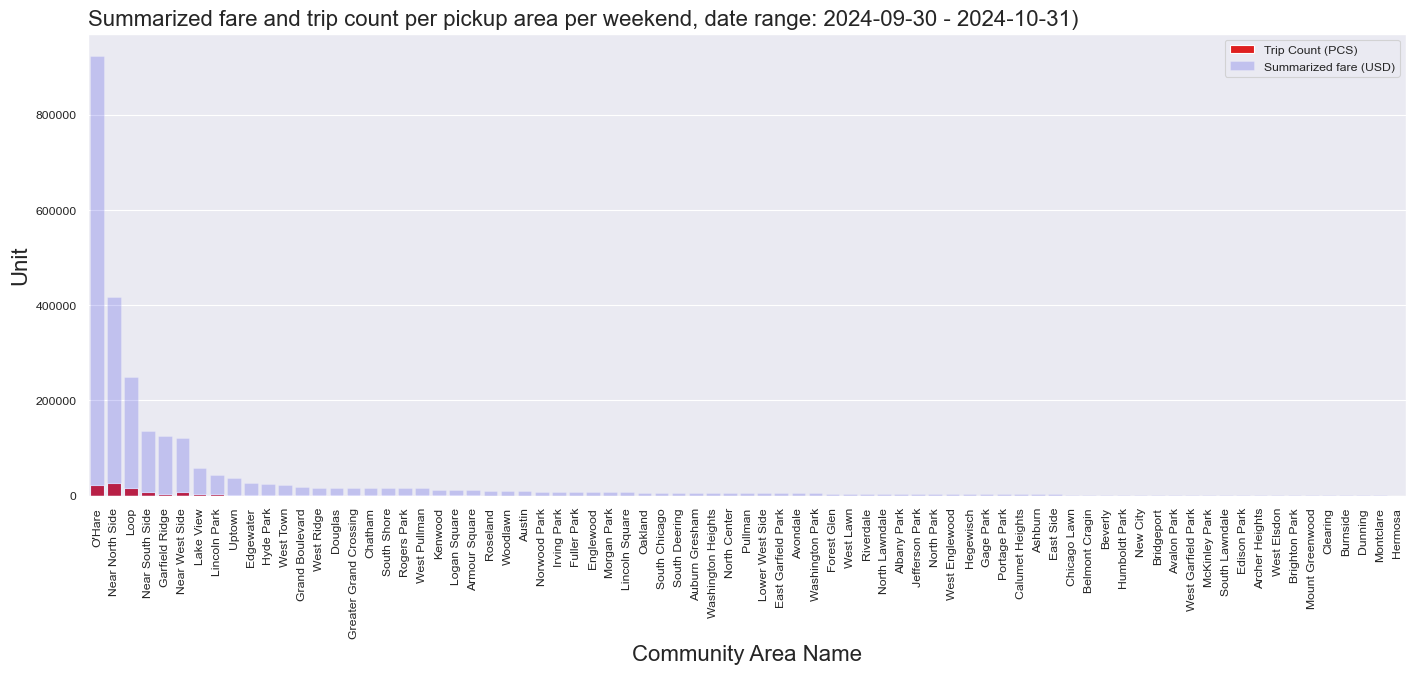

In [31]:
plt.figure(figsize=(17, 6))

sns.barplot(
    x='pickup_community_area_name', 
    y='trip_count', 
    data=query_for_pickup_community_area_on_weekend, 
    color='red', 
    label='Trip Count (PCS)'
)
sns.barplot(
    x='pickup_community_area_name', 
    y='sum_fare', 
    data=query_for_pickup_community_area_on_weekend, 
    color='blue', 
    alpha=0.2, 
    label='Summarized fare (USD)'
)
plt.title(f'Summarized fare and trip count per pickup area per weekend, date range: {date_for_visualisation_title})', fontsize=16, loc= 'left')
plt.xlabel('Community Area Name', fontsize=16)
plt.xticks(rotation=90)
plt.ylabel('Unit', fontsize=16)

plt.show()

In [32]:
# pandas melt fuction is used to add all income to company
query_for_company_melted = query_for_company.melt(id_vars='company', 
                  value_vars=['Total_fare_(USD)', 'Total_trips_(USD)', 'Total_extras_(USD)'],
                  var_name='Income',
                  value_name='value')

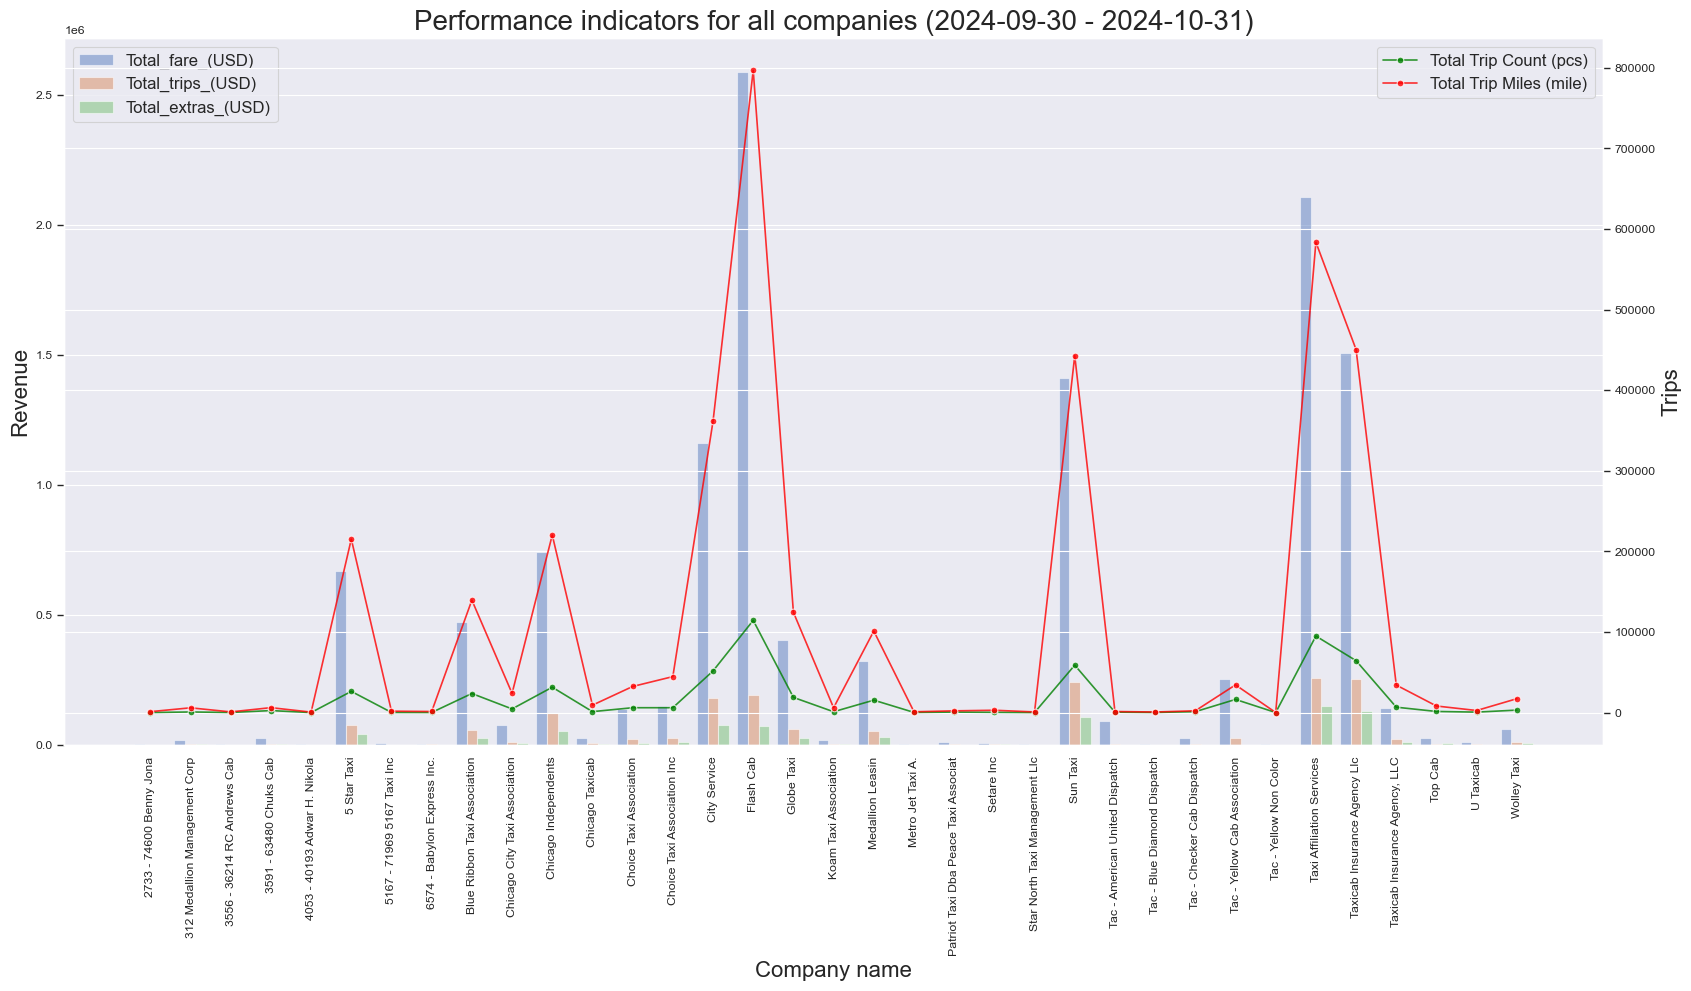

In [33]:
fig, ax1 = plt.subplots(figsize=(17, 10))

# bar plot for revenue data from melted DataFrame
sns.barplot(
    data=query_for_company_melted,
    x='company',
    y='value',
    alpha=0.5,
    hue='Income',
    ax=ax1
)

# set bar plot labels and title
ax1.set_title(f'Performance indicators for all companies ({date_for_visualisation_title})', fontsize=20)
ax1.set_xlabel('Company name', fontsize=16)
ax1.set_ylabel('Revenue', fontsize=16)
ax1.tick_params(axis='x', rotation=90)
ax1.legend(loc='upper left', fontsize=12)

# create a secondary y-axis for the line plots
ax2 = ax1.twinx()

# 2 line plots for Total_trips and Total_trip_miles per company
sns.lineplot(
    data=query_for_company,
    x='company',
    y='count(trip_id)',
    marker='o',
    color='green',
    alpha=0.8,
    label='Total Trip Count (pcs)',
    ax=ax2
)
sns.lineplot(
    data=query_for_company,
    x='company',
    y='Total_trip_miles',
    marker='o',
    color='red',
    alpha=0.8, 
    label='Total Trip Miles (mile)',
    ax=ax2
)

# Set labels for the secondary axis
ax2.set_ylabel('Trips', fontsize=16)
ax2.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

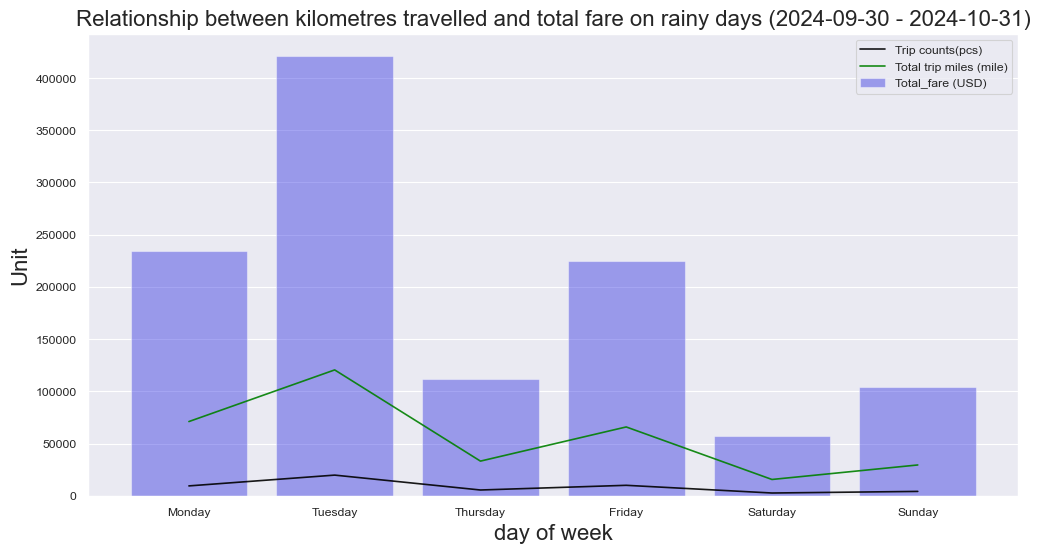

In [34]:
plt.figure(figsize=(12, 6))

sns.lineplot(
    x='day_name', 
    y='trip_count', 
    data=query_for_rainy_days, 
    color='black', 
    alpha=0.9, 
    label= 'Trip counts(pcs)'
)
sns.barplot(
    x='day_name', 
    y='total_fare', 
    data=query_for_rainy_days, 
    color='blue', 
    alpha=0.4, 
    label= 'Total_fare (USD)'
)
sns.lineplot(
    x='day_name', 
    y='total_trip_miles', 
    data=query_for_rainy_days, 
    color='green', 
    alpha=0.9, 
    label='Total trip miles (mile)'
)

plt.title(f'Relationship between kilometres travelled and total fare on rainy days ({date_for_visualisation_title})', fontsize=16)
plt.xlabel('day of week', fontsize=16)
plt.ylabel('Unit', fontsize=16)

plt.show()

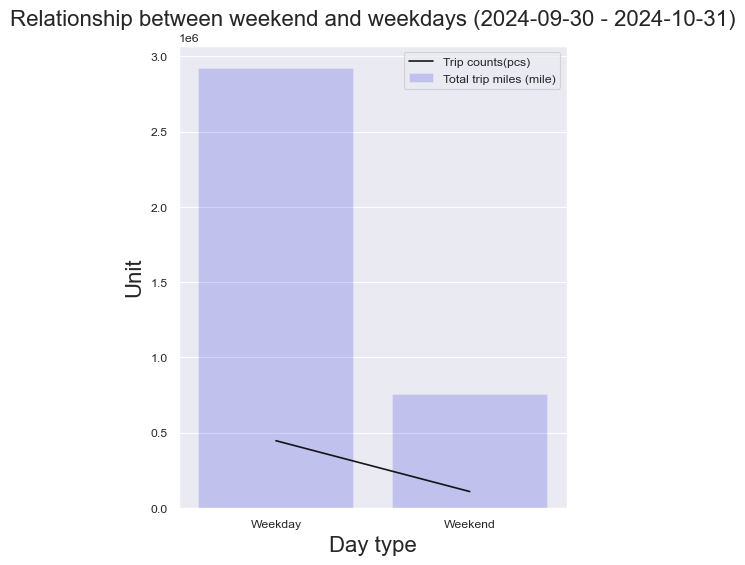

In [113]:
plt.figure(figsize=(5, 6))

sns.lineplot(
    x='day_type', 
    y='trip_count', 
    data=query_for_weekend_vs_weekday, 
    color='black', 
    alpha=0.9, 
    label= 'Trip counts(pcs)'
)
sns.barplot(
    x='day_type', 
    y='total_trip_miles', 
    data=query_for_weekend_vs_weekday, 
    color='blue', 
    alpha=0.2, 
    label= 'Total trip miles (mile)'
)

plt.title(f'Relationship between weekend and weekdays ({date_for_visualisation_title})', fontsize=16)
plt.xlabel('Day type', fontsize=16)
plt.ylabel('Unit', fontsize=16)

plt.show()

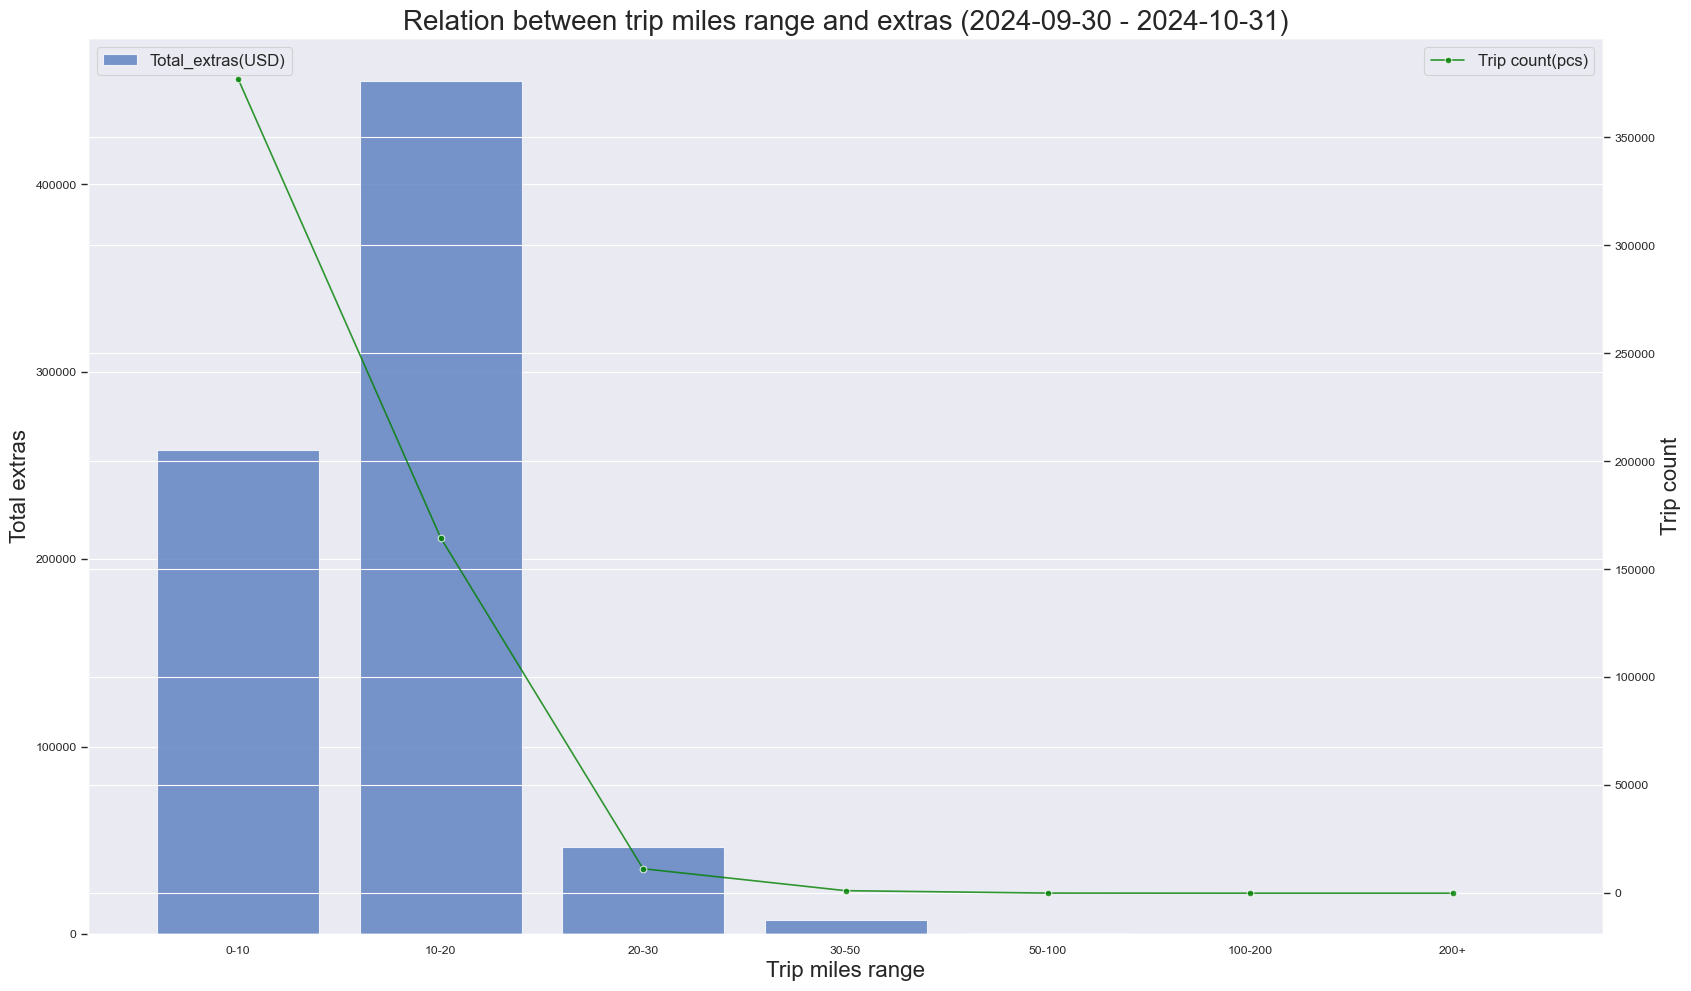

In [117]:
fig, ax1 = plt.subplots(figsize=(17, 10))

sns.barplot(
    data=query_for_extra,
    x='trip_miles_range',
    y='total_extras',
    alpha=0.8,
    ax=ax1,
    label= 'Total_extras(USD)'
)

# set bar plot labels and title
ax1.set_title(f'Relation between trip miles range and extras ({date_for_visualisation_title})', fontsize=20)
ax1.set_xlabel('Trip miles range', fontsize=16)
ax1.set_ylabel('Total extras', fontsize=16)
ax1.legend(loc='upper left', fontsize=12)


# create a secondary y-axis for the line plots
ax2 = ax1.twinx()

# 2 line plots for Total_trips and Total_trip_miles per company
sns.lineplot(
    data=query_for_extra,
    x='trip_miles_range',
    y='trip_count',
    marker='o',
    color='green',
    alpha=0.8,
    label='Trip count(pcs)',
    ax=ax2
)

# Set labels for the secondary axis
ax2.set_ylabel('Trip count', fontsize=16)
ax2.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()